# Exchange data between servers {#ref_exchange_data_between_servers.}

In this example, two DPF servers are started, and a workflow is created
with a part on both servers. This example shows how you can read data
from a given machine and transform this data on another machine without
any more difficulties than working on a local computer.


In [1]:
from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops

# Create two servers

Use the
`start_local_server() <ansys.dpf.core.server.start_local_server>`{.interpreted-text
role="func"} method to start two servers on your local machine. If you
have another server, you can use the
`connect_to_server() <ansys.dpf.core.server.connect_to_server>`{.interpreted-text
role="func"} method to connect to any DPF server on your network.

The `as_global` attributes allows you to choose whether a server is
stored by the module and used by default. This example sets the first
server as the default.


In [2]:
server1 = dpf.start_local_server(as_global=True, config=dpf.AvailableServerConfigs.GrpcServer)
server2 = dpf.start_local_server(as_global=False, config=dpf.AvailableServerConfigs.GrpcServer)

# Check that the two servers are listening on different ports.
print(
    server1.port if hasattr(server1, "port") else "",
    server2.port if hasattr(server2, "port") else "",
)

50054 50055


# Send the result file

The result file is sent to the temporary directory of the first server.
This file upload is useless in this case because the two servers are
local machines.


In [3]:
file_path_in_tmp = examples.find_complex_rst(server=server1)

# Create a workflow on the first server

Create the model


In [4]:
model = dpf.Model(file_path_in_tmp)

# Read displacement
disp = model.results.displacement()
disp.inputs.time_scoping(len(model.metadata.time_freq_support.time_frequencies))

# Create a workflow on the second server


In [5]:
# Change the Cartesian coordinates to cylindrical coordinates cs
coordinates = ops.geo.rotate_in_cylindrical_cs_fc(server=server2)

# Create the Cartesian coordinate cs
cs = dpf.fields_factory.create_scalar_field(12, server=server2)
cs.data = [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]

coordinates.inputs.coordinate_system(cs)

# Choose the radial component to plot
comp = dpf.operators.logic.component_selector_fc(coordinates, 0, server=server2)

# Pass data from one server to another


In [6]:
fc_disp = disp.outputs.fields_container()
fc_copy = fc_disp.deep_copy(server=server2)

mesh_copy = model.metadata.meshed_region.deep_copy(server=server2)
# give a mesh to the field
fc_copy[0].meshed_region = mesh_copy
fc_copy[1].meshed_region = mesh_copy

coordinates.inputs.field(fc_copy)

# Plot the output


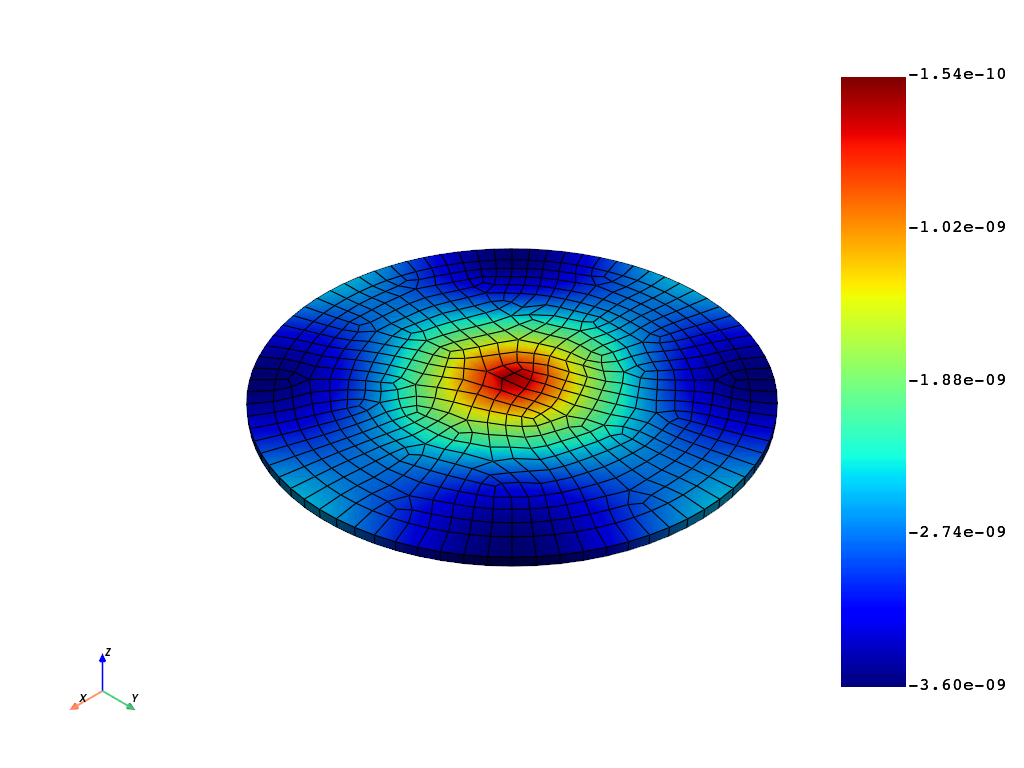

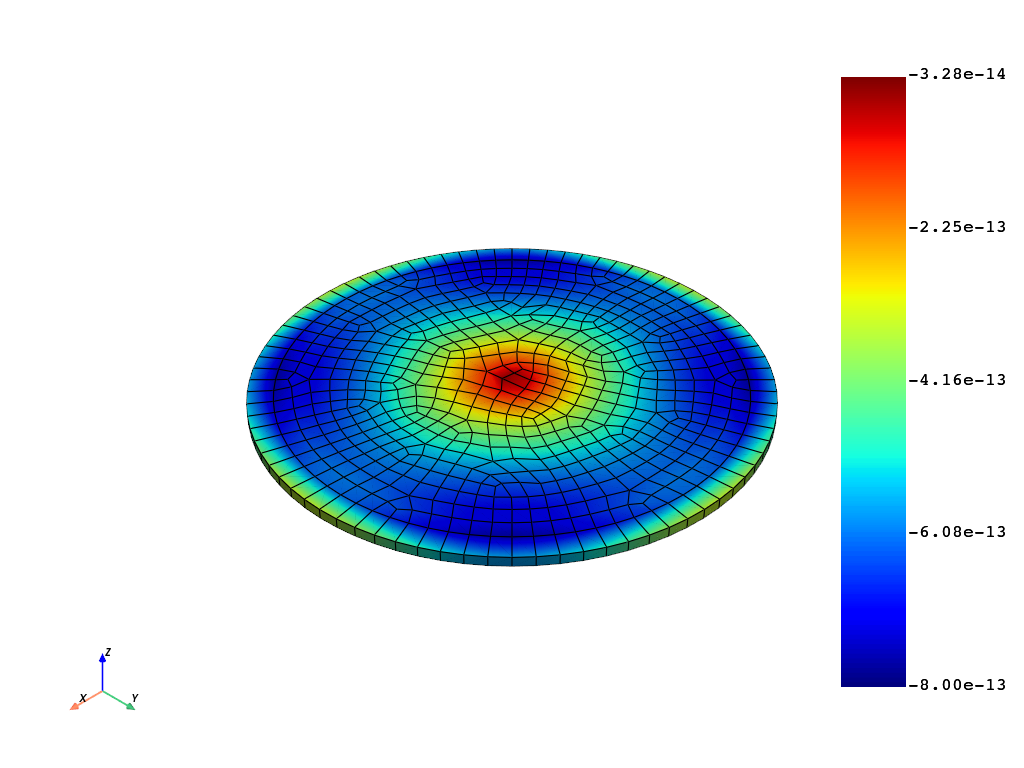

In [7]:
out = comp.outputs.fields_container()

# real part
mesh_copy.plot(out.get_field({"complex": 0}))

# imaginary part
mesh_copy.plot(out.get_field({"complex": 1}))